# Don't Get Kicked
##### Predict if a car purchased at auction is a lemon

Researcher: Ryan Brown

Date: 2022.08.18

## `Import Packages & Configure Globals`

In [1]:
# package loads
from collections import Counter
from matplotlib.lines import Line2D
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import random
import re
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection._base import SelectorMixin
from sklearn.feature_extraction.text import _VectorizerMixin, CountVectorizer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, average_precision_score, confusion_matrix, ConfusionMatrixDisplay, \
                            precision_score, precision_recall_curve, recall_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import FunctionTransformer, Pipeline
from sklearn.preprocessing import OneHotEncoder, MaxAbsScaler, StandardScaler
from sklearn.preprocessing import Binarizer, StandardScaler
import time
from xgboost import XGBClassifier

# set all seeds to make runs deterministic
seed = 1534
random.seed(seed)
np.random.seed(seed)

# set globals
raw_dir = '../data/raw'
train_path = f'{raw_dir}/training.csv'

## `Load Data`

In [2]:
# note -- loading train only, as test witholds target, specs only mention train
train_raw = pd.read_csv(train_path)

## `Pre-Processing`
In this section we will briefly review our data, and try to parse out any inconsistencies

*Note: this is not an EDA; EDA will be conducted after a test set is withheld*

In [3]:
# let's start by reviewing the data

train_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72983 entries, 0 to 72982
Data columns (total 34 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   RefId                              72983 non-null  int64  
 1   IsBadBuy                           72983 non-null  int64  
 2   PurchDate                          72983 non-null  object 
 3   Auction                            72983 non-null  object 
 4   VehYear                            72983 non-null  int64  
 5   VehicleAge                         72983 non-null  int64  
 6   Make                               72983 non-null  object 
 7   Model                              72983 non-null  object 
 8   Trim                               70623 non-null  object 
 9   SubModel                           72975 non-null  object 
 10  Color                              72975 non-null  object 
 11  Transmission                       72974 non-null  obj

In [4]:
# let's fix a few dtypes

# PurchDate to datetype
train_raw['PurchDate'] = pd.to_datetime(train_raw['PurchDate'], format='%m/%d/%Y')

# BYRNO to str
train_raw['BYRNO'] = train_raw['BYRNO'].astype(str)

# PRIMEUNIT to bool
train_raw['PRIMEUNIT'] = train_raw['PRIMEUNIT'].replace(
    {
        'YES':1,
        'NO':0
    }
).fillna(0).astype(bool)

# IsOnlineSale to bool
train_raw['IsOnlineSale'] = train_raw['IsOnlineSale'].astype(bool)
    
# zip to 0 pad str
train_raw['VNZIP1'] = train_raw['VNZIP1'].astype(str).str.zfill(5)

C:\Users\ry_w_\AppData\Local\Temp\ipykernel_17248\3004406980.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)


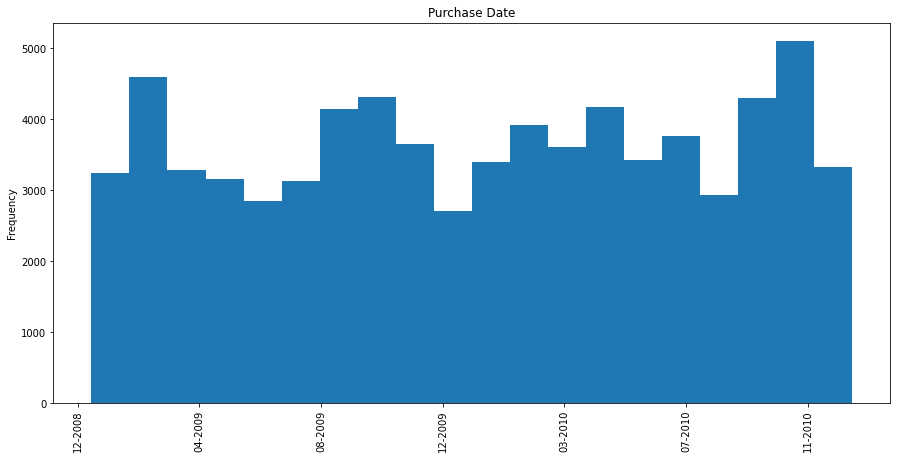

In [5]:
# let's briefly look at the time distribution so we know if this will be an issue
fig, ax = plt.subplots(figsize=(15,7))

train_raw['PurchDate'].astype(np.int64).plot.hist(ax=ax, bins=20)
labels = ax.get_xticks().tolist()
labels = pd.to_datetime(labels).strftime('%m-%Y')
ax.set_xticklabels(labels, rotation=90)
ax.set_title('Purchase Date')
plt.show()

data are somewhat cyclical; we could consider additional embeddings, but given the scope, we'll just settle for categorically encoding them to less granular fields

In [6]:
# let's convert that to categoricals for year, month
train_raw['PurchYear'], train_raw['PurchMonth'] = train_raw['PurchDate'].dt.year, train_raw['PurchDate'].dt.month
    
# convert year/month to strings given low cardinality
train_raw['PurchYear'], train_raw['PurchMonth'] = train_raw['PurchYear'].astype(str), train_raw['PurchMonth'].astype(str)

In [7]:
# drop actual date
train_raw = train_raw.drop(['PurchDate'], axis=1)

In [8]:
# let's view uniques for a few columns to assess

# 1. RefId -- constant
train_raw.RefId.value_counts()[:5]

1        1
48678    1
48684    1
48683    1
48682    1
Name: RefId, dtype: int64

In [9]:
# 2. WheelTypeID -- redundant
train_raw[['WheelTypeID', 'WheelType']].drop_duplicates()

,WheelTypeID,WheelType
0,1.0,Alloy
2,2.0,Covers
39,NaN,NaN
212,3.0,Special
2992,0.0,NaN


In [10]:
# 3. TopThreeAmericanName -- some overlap but possibly worth keeping
(train_raw.TopThreeAmericanName + '--' + train_raw.Make).value_counts()[:15]

GM--CHEVROLET         17248
CHRYSLER--DODGE       12911
FORD--FORD            11305
CHRYSLER--CHRYSLER     8844
GM--PONTIAC            4258
OTHER--KIA             2484
GM--SATURN             2163
OTHER--NISSAN          2085
OTHER--HYUNDAI         1810
CHRYSLER--JEEP         1642
OTHER--SUZUKI          1328
OTHER--TOYOTA          1144
OTHER--MITSUBISHI      1030
OTHER--MAZDA            979
FORD--MERCURY           913
dtype: int64

In [11]:
# 4. VehYear -- redundant
np.corrcoef(train_raw.VehYear, train_raw.VehicleAge)

array([[ 1.        , -0.95795707],
       [-0.95795707,  1.        ]])

In [12]:
# remove a few columns that don't add predictive value

train_raw = train_raw.drop(
    columns = {
        'RefId', # constant
        'WheelTypeID', # redundant with WheelType
        'VehYear' # redundant with VehicleAge
    },
    index=1
)

In [13]:
# let's look at unique values for Transmission
train_raw.Transmission.value_counts()

AUTO      70397
MANUAL     2575
Manual        1
Name: Transmission, dtype: int64

In [14]:
# don't want to spend too much time parsing;
# but to avoid the above let's convert all str to lower

categoricals = train_raw.select_dtypes('object').columns
train_raw[categoricals] = train_raw[categoricals].apply(lambda x: x.str.lower())

## `Sampling`

In [15]:
# we'll start by segmenting our data into a 70-15-15 train/valid/test split;

# split labels from data
X, y = train_raw.drop(['IsBadBuy'], axis=1), train_raw.IsBadBuy

# split train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=seed,
    stratify=y # stratify on target
)

# split train and test
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=(15/85), random_state=seed,
    stratify=y_train # stratify on target
)

print(f'train size: {Counter(y_train)}')
print(f'valid size: {Counter(y_valid)}')
print(f'test size: {Counter(y_test)}')

train size: Counter({0: 44803, 1: 6283})
valid size: Counter({0: 9601, 1: 1347})
test size: Counter({0: 9602, 1: 1346})


## `Exploratory Analysis`

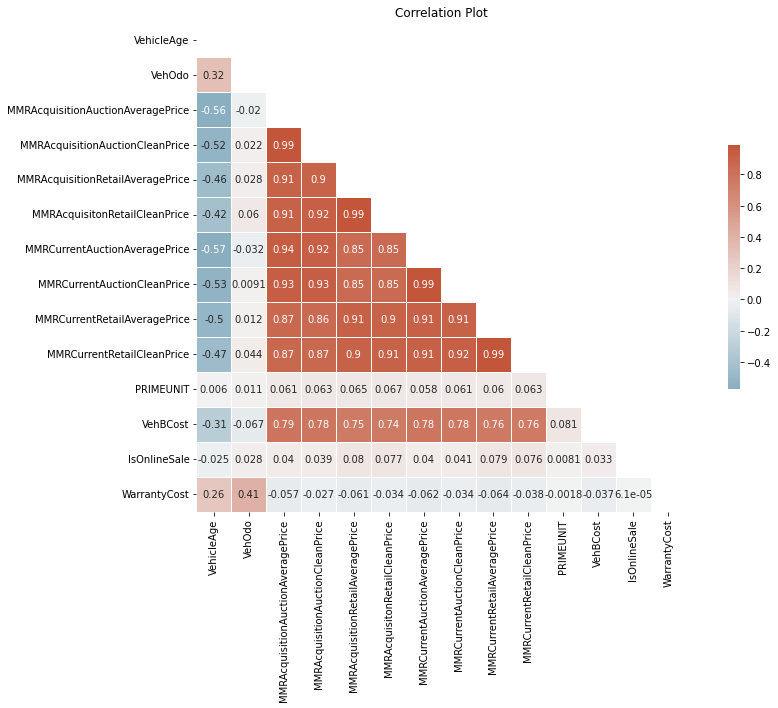

In [16]:
# let's start by looking at a corrplot of all our features
import seaborn as sns

# Compute the correlation matrix
corr = X_train.select_dtypes(exclude=['object', 'datetime']).corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(15, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, annot=True, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

ax.set_title('Correlation Plot')
plt.show()

In [17]:
# let's try a PCA to reduce these heavily correlated market price features

# make a pipeline to perform PCA
pca_base_pipe = Pipeline(steps=[
    ('impute', SimpleImputer(missing_values=np.nan, strategy='mean')), # replace missing with mean
    ('scale', StandardScaler()), # scale
    ('pca', PCA(n_components=8, random_state=seed))]) # pca

# fit to market cols
market_prices = [c for c in X_train.columns if re.match('^MMR.+Price$', c)]
pca_base_pipe.fit(X_train[market_prices])

Pipeline(steps=[('impute', SimpleImputer()), ('scale', StandardScaler()),
                ('pca', PCA(n_components=8, random_state=1534))])

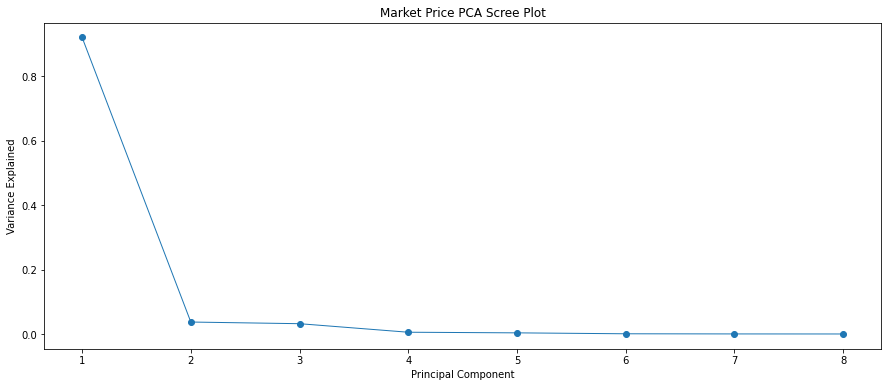

In [18]:
# visualize PCA with scree plot

# make plots
fig, ax = plt.subplots(figsize=(15, 6))

components = np.arange(pca_base_pipe['pca'].n_components_) + 1
plt.plot(components, pca_base_pipe['pca'].explained_variance_ratio_, 'o-', linewidth=1)
plt.title('Market Price PCA Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

looks like we can capture the vast majority of the variance with one component

In [19]:
# switching gears to categoricals, let's look at cardinality

X_train[X_train.select_dtypes('object').columns].nunique().reset_index(name='cardinality')

,index,cardinality
0,Auction,3
1,Make,33
2,Model,1008
3,Trim,131
4,SubModel,797
5,Color,16
6,Transmission,2
7,WheelType,3
8,Nationality,4
9,Size,12


In [20]:
# for most of these, we will restrict OHE to most frequent, but model and submodel we will try word vectors

X_train['SubModel'].value_counts()[:10]

4d sedan            10642
4d sedan ls          3293
4d sedan se          2716
4d wagon             1571
minivan 3.3l          867
4d suv 4.2l ls        846
4d sedan lt           798
4d sedan sxt ffv      766
4d sedan lx           760
2d coupe              739
Name: SubModel, dtype: int64

In [21]:
X_train['Model'].value_counts()[:10]

pt cruiser              1603
impala                  1403
taurus                   985
caliber                  980
caravan grand fwd v6     878
malibu 4c                872
sebring 4c               817
taurus 3.0l v6 efi       810
pt cruiser 2.4l i4 s     780
1500 ram pickup 2wd      778
Name: Model, dtype: int64

## `Modeling`

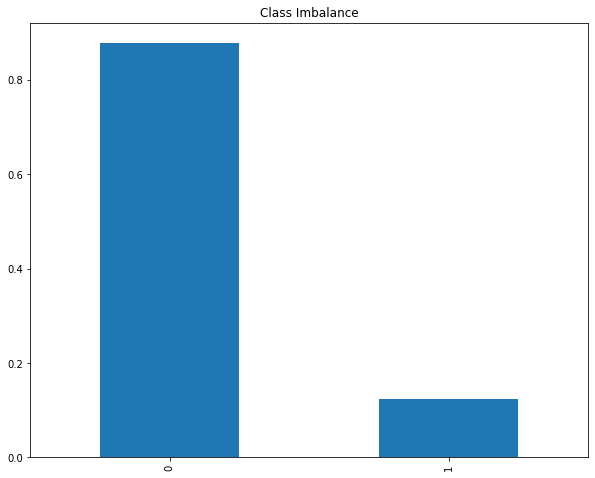

In [22]:
# examine class imbalance

y_train.value_counts(normalize=True).plot(kind='bar', title='Class Imbalance', figsize=(10,8))
plt.show()

In [23]:
# calculate class weights to apply to loss to prevent bias towards majority class

n_pos = len(y_train[y_train==1])
n_neg = len(y_train[y_train==0])
n_tot = n_pos + n_neg
n_classes = 2

# weigh by inverse class occurence
# scaling by total/n_classes helps keep loss to similar magnitude
# inspired by Logistic Regression in Rare Events Data; King, Zen, 2001. (https://gking.harvard.edu/files/0s.pdf)
weight_pos = (1/n_pos) * (n_tot/n_classes)
weight_neg = (1/n_neg) * (n_tot/n_classes)

# adjust scale so neg class has weight of 1; compatible with xgb scale_pos_weight
pos_weight_ratio = weight_pos/weight_neg

class_weight = {
    1: pos_weight_ratio*1,
    0: 1
}

class_weight

{1: 7.130829221709374, 0: 1}

In [24]:
# define functions to build classifier pipeline

def make_vectorizer(max_features=50):
    """ return vectorization pipe """
    vec_pipe = Pipeline(
        steps=[
            ('replace_na', SimpleImputer(strategy='constant', fill_value='')),
            ('flatten', FunctionTransformer(np.reshape, kw_args={'newshape':-1})),
            ('count_vectorizer', CountVectorizer(analyzer='word', max_features=max_features, binary=True))
        ]
    )
    
    return vec_pipe

def build_preprocesser():
    """ 
    function to build and return preprocessing pipeline
    """
    model_vec_pipe = make_vectorizer()

    submodel_vec_pipe = make_vectorizer()

    # build out new pca pipe based on earlier study
    pca_pipe = Pipeline(
        steps=[
            ('impute', SimpleImputer(missing_values=np.nan, strategy='mean')), # replace missing with mean
            ('scale', StandardScaler()), # scale
            ('pca', PCA(n_components=1, random_state=seed)) # pca; set to 1 based on scree study
        ]
    )

    # build out full transformer
    preprocessing_ct = ColumnTransformer(
        transformers=[
            ('median_imputer', SimpleImputer(missing_values=np.nan, strategy='median'), # median impute for discrete
             make_column_selector(dtype_include='int64')), # age, odo, and warranty cost are the only ints
            ('mean_imputer', SimpleImputer(missing_values=np.nan, strategy='mean'), # mean impute desired floats
             ['VehBCost']), # apply this explicity for veh buy, PCA pipe will handle market prices
            ('binarizer', Binarizer(), # bool to ints
             make_column_selector(dtype_include='bool')),
            ('mmr_price_pca',  pca_pipe, # this will be our pca layer
             make_column_selector(pattern='^MMR.+Price')), # only select MMR prices
            ('ohe', OneHotEncoder(drop='first', min_frequency=30, handle_unknown='infrequent_if_exist', 
                                  max_categories=50), # reg here to prevent overfitting
             list(set(X_train.select_dtypes('object').columns)-{'Model', 'SubModel'})), # want cats but vec will handle models
            ('model_vec',  model_vec_pipe, # this will vectorize car model
             ['Model']), # only select Model
            ('submodel_vec',  submodel_vec_pipe, # this will vectorize car submodel
             ['SubModel'])
        ],
        remainder='passthrough'
    )
    
    preprocessing_pipe = Pipeline(
        steps=[
            ('preprocess', preprocessing_ct), # apply preprocessing
            ('scale_all', MaxAbsScaler()) # scale all again to collect any previously unscaled
        ]
    )
    
    return preprocessing_pipe


def build_classifier(clf):
    """ 
    function to build and return classification pipeline 
    
    parameters:
        preprocessing_pipe: fit preprocesser
        clf: classifier to test
    returns:
        model_pipe: clf pipeline
    
    """

    # build out the model pipe to allow space for additional modeling layers
    model_pipe = Pipeline(
        steps=[
            ('cf', clf) # classify
        ]
    )
    
    return model_pipe


In [25]:
# let's define our eval measures

# define kaggle comp eval measure
def gini_score(y_true, y_score):
    """ function to return kaggle gini eval measure """
    all_ = np.asarray(np.c_[y_true, y_score, np.arange(len(y_true))], 
                      dtype=np.float64)
    all_ = all_[np.lexsort((all_[:,2], -1*all_[:,1]))]
    totalLosses = all_[:,0].sum()
    giniSum = all_[:,0].cumsum().sum() / totalLosses

    giniSum -= (len(y_true) + 1) / 2.
    return giniSum / len(y_true)

def minimize_gini_score(y_true, y_score):
    """ xgb only accepts min=good eval metrics """
    return 1-gini_score(y_true, y_score)

# define scores to test
scoring = {
    'accuracy': (accuracy_score, 'preds'),
    'precision': (precision_score, 'preds'),
    'recall': (recall_score, 'preds'),
    'auc roc': (roc_auc_score, 'probs'),
    'avg. precision': (average_precision_score, 'probs'),
    'gini index': (gini_score, 'probs')
}

In [26]:
# fit preprocesser and transform Xs

preprocesser = build_preprocesser()
preprocesser.fit(X_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('median_imputer',
                                                  SimpleImputer(strategy='median'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000029D1CAEAB30>),
                                                 ('mean_imputer',
                                                  SimpleImputer(),
                                                  ['VehBCost']),
                                                 ('binarizer', Binarizer(),
                                                  <sklearn.compose._column_transformer.make_column_selecto...
                                                                   CountVectorizer(binary=True,
                                                                                   max_features=50))]),
                                                  ['Model']),
                                                 ('submodel_vec',
                                                  Pipeline(steps=[('replace_na',
                                                                   SimpleImputer(fill_value='',
                                                                                 strategy='constant')),
                                                                  ('flatten',
                                                                   FunctionTransformer(func=<function reshape at 0x0000029D70F59750>,
                                                                                       kw_args={'newshape': -1})),
                                                                  ('count_vectorizer',
                                                                   CountVectorizer(binary=True,
                                                                                   max_features=50))]),
                                                  ['SubModel'])])),
                ('scale_all', MaxAbsScaler())])

In [27]:
# transform frames to minimize loading

X_train_trans = preprocesser.transform(X_train)
X_valid_trans = preprocesser.transform(X_valid)
X_test_trans = preprocesser.transform(X_test)

C:\Users\ry_w_\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3, 7, 10] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [28]:
clf_lst = [
    ('logistic regression', LogisticRegression(max_iter=1e3, class_weight=class_weight, random_state=seed)),
    ('knn', KNeighborsClassifier(3)), # simple knn with k=3
    ('rf', RandomForestClassifier(class_weight=class_weight, 
                                  n_estimators=100, # max rounds
                                  min_impurity_decrease=0.01, # regularization param
                                  random_state=seed)),
    ('xgb', XGBClassifier(scale_pos_weight=class_weight[1], # balance classes here
                          eval_metric=minimize_gini_score, 
                          early_stopping_rounds=10, # terminate on val converg.
                          max_depth=3, # limit complexity
                          learning_rate=0.1, # alpha applied to gradient
                          n_estimators=500, # max rounds (limited by early stopping)
                          random_state=seed
                         ))
]

# preset objs to save models/perf to 
score_df = pd.DataFrame()
model_dict = {}
preds_dict = {}
probs_dict = {}
# iterate through classifiers
for clf_label, clf_i in clf_lst:
    # set start time to track execution load
    start_time = time.time()
    
    print(f'training model {clf_label}------------------')
    
    # build
    model_i = build_classifier(clf_i)
    
    # fit
    if clf_label != 'xgb':
        model_i.fit(X_train_trans, y_train)
    else:
        model_i.fit(X_train_trans, y_train, cf__eval_set=[(X_train_trans, y_train), 
                                                          (X_valid_trans, y_valid)]) # used to terminate boosting
    
    # preds
    model_i_preds_train = model_i.predict(X_train_trans)
    model_i_preds_valid = model_i.predict(X_valid_trans)

    # probs
    model_i_probs_train = model_i.predict_proba(X_train_trans)[:,1]
    model_i_probs_valid = model_i.predict_proba(X_valid_trans)[:,1]
    
    #save to dicts
    model_dict[clf_label] = model_i
    preds_dict[clf_label] = {
        'train': model_i_preds_train,
        'valid': model_i_preds_valid
    }
    probs_dict[clf_label] = {
        'train': model_i_probs_train,
        'valid': model_i_probs_valid
    }
    
    # save scores to row
    score_row = {'algorithm': clf_label}
    for score_label, score_tup in scoring.items():
        score, score_type = score_tup
        if score_type == 'preds':
            score_row[f'train {score_label}'] = [round(score(y_train, model_i_preds_train), 4)]
            score_row[f'valid {score_label}'] = [round(score(y_valid, model_i_preds_valid), 4)]
        elif score_type == 'probs':
            score_row[f'train {score_label}'] = [round(score(y_train, model_i_probs_train), 4)]
            score_row[f'valid {score_label}'] = [round(score(y_valid, model_i_probs_valid), 4)]
    
    # save time
    score_row['exec. time'] = [(time.time() - start_time)]
    # save row to df
    score_df = pd.concat([score_df, pd.DataFrame(score_row)], ignore_index=True)
    
    print('completed!')


training model logistic regression------------------
completed!
training model knn------------------
completed!
training model rf------------------
completed!
training model xgb------------------
[0]	validation_0-logloss:0.67569	validation_0-minimize_gini_score:0.80445	validation_1-logloss:0.67612	validation_1-minimize_gini_score:0.79851
[1]	validation_0-logloss:0.66097	validation_0-minimize_gini_score:0.80115	validation_1-logloss:0.66175	validation_1-minimize_gini_score:0.79540
[2]	validation_0-logloss:0.64833	validation_0-minimize_gini_score:0.79627	validation_1-logloss:0.64933	validation_1-minimize_gini_score:0.78899
[3]	validation_0-logloss:0.63749	validation_0-minimize_gini_score:0.79197	validation_1-logloss:0.63888	validation_1-minimize_gini_score:0.78680
[4]	validation_0-logloss:0.62788	validation_0-minimize_gini_score:0.79054	validation_1-logloss:0.62949	validation_1-minimize_gini_score:0.78435
[5]	validation_0-logloss:0.61960	validation_0-minimize_gini_score:0.79058	validation

[56]	validation_0-logloss:0.54543	validation_0-minimize_gini_score:0.76187	validation_1-logloss:0.55403	validation_1-minimize_gini_score:0.76257
[57]	validation_0-logloss:0.54522	validation_0-minimize_gini_score:0.76170	validation_1-logloss:0.55379	validation_1-minimize_gini_score:0.76235
[58]	validation_0-logloss:0.54487	validation_0-minimize_gini_score:0.76125	validation_1-logloss:0.55344	validation_1-minimize_gini_score:0.76199
[59]	validation_0-logloss:0.54457	validation_0-minimize_gini_score:0.76097	validation_1-logloss:0.55316	validation_1-minimize_gini_score:0.76180
[60]	validation_0-logloss:0.54420	validation_0-minimize_gini_score:0.76054	validation_1-logloss:0.55294	validation_1-minimize_gini_score:0.76174
[61]	validation_0-logloss:0.54387	validation_0-minimize_gini_score:0.76019	validation_1-logloss:0.55260	validation_1-minimize_gini_score:0.76161
[62]	validation_0-logloss:0.54364	validation_0-minimize_gini_score:0.75987	validation_1-logloss:0.55243	validation_1-minimize_gini

[113]	validation_0-logloss:0.53324	validation_0-minimize_gini_score:0.74893	validation_1-logloss:0.54417	validation_1-minimize_gini_score:0.75707
[114]	validation_0-logloss:0.53304	validation_0-minimize_gini_score:0.74867	validation_1-logloss:0.54401	validation_1-minimize_gini_score:0.75704
[115]	validation_0-logloss:0.53289	validation_0-minimize_gini_score:0.74848	validation_1-logloss:0.54393	validation_1-minimize_gini_score:0.75701
[116]	validation_0-logloss:0.53268	validation_0-minimize_gini_score:0.74826	validation_1-logloss:0.54367	validation_1-minimize_gini_score:0.75672
[117]	validation_0-logloss:0.53253	validation_0-minimize_gini_score:0.74812	validation_1-logloss:0.54356	validation_1-minimize_gini_score:0.75664
[118]	validation_0-logloss:0.53241	validation_0-minimize_gini_score:0.74807	validation_1-logloss:0.54339	validation_1-minimize_gini_score:0.75657
[119]	validation_0-logloss:0.53225	validation_0-minimize_gini_score:0.74787	validation_1-logloss:0.54325	validation_1-minimi

## `Evaluation`

In [29]:
score_df

,algorithm,train accuracy,valid accuracy,train precision,valid precision,train recall,valid recall,train auc roc,valid auc roc,train avg. precision,valid avg. precision,train gini index,valid gini index,exec. time
0,logistic regression,0.7439,0.7380,0.2728,0.2640,0.6497,0.6318,0.7810,0.7703,0.4467,0.4533,0.2464,0.2371,1.122931
1,knn,0.9045,0.8603,0.7691,0.3064,0.3196,0.1069,0.9307,0.5847,0.5507,0.1663,0.3777,0.0781,171.391814
2,rf,0.7231,0.7094,0.2383,0.2290,0.5701,0.5754,0.7233,0.7204,0.3685,0.3717,0.1955,0.1936,1.283990
3,xgb,0.7567,0.7463,0.2839,0.2741,0.6430,0.6444,0.7903,0.7783,0.4912,0.4802,0.2546,0.2441,4.706019


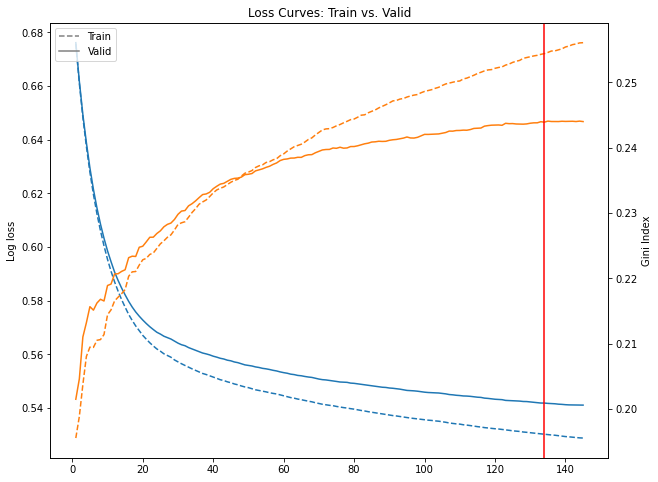

In [30]:
# looks like XGB reigns supreme, and it's relatively fast! let's checkout the loss curves

fig, ax = plt.subplots(figsize=(10,8))
ax2 = ax.twinx() # twin x

# train
train_logloss_history = model_dict['xgb'].steps[0][1].evals_result_['validation_0']['logloss']
train_gini_history = [1-x_ for x_ in model_dict['xgb'].steps[0][1].evals_result_['validation_0']['minimize_gini_score']]

# valid
valid_logloss_history = model_dict['xgb'].steps[0][1].evals_result_['validation_1']['logloss']
valid_gini_history = [1-x_ for x_ in model_dict['xgb'].steps[0][1].evals_result_['validation_1']['minimize_gini_score']]

n_epochs = len(valid_logloss_history)

ax.plot(np.arange(1, n_epochs+1), train_logloss_history, label='train', color='C0', linestyle='--')
ax.plot(np.arange(1, n_epochs+1), valid_logloss_history, label='valid', color='C0')

ax2.plot(np.arange(1, n_epochs+1), train_gini_history, label='train', color='C1', linestyle='--')
ax2.plot(np.arange(1, n_epochs+1), valid_gini_history, label='valid', color='C1')

# display termination
plt.axvline(x=model_dict['xgb'].steps[0][1].best_iteration, color='r')

ax.set_ylabel('Log loss')
ax2.set_ylabel('Gini Index')

# make legend
custom_lines = [Line2D([0], [0], color='gray', linestyle='--'),
                Line2D([0], [0], color='gray')]

ax.legend(custom_lines, ['Train', 'Valid'], loc='upper left')

plt.title('Loss Curves: Train vs. Valid')
plt.show()

looks like we're converging, overfitting a tad, but we can tune this later on

In [31]:
# now let's evaluate xgb on test

# get preds/probs
preds_dict['xgb']['test'] = model_i.predict(X_test_trans)
probs_dict['xgb']['test'] = model_i.predict_proba(X_test_trans)[:,1]

# print scores as df
test_row = {'label': 'xgb test perf.'}
for score_label, score_tup in scoring.items():
    score, score_type = score_tup
    if score_type == 'preds':
        test_row[score_label] = [round(score(y_test, preds_dict['xgb']['test']), 4)]
    elif score_type == 'probs':
        test_row[score_label] = [round(score(y_test, probs_dict['xgb']['test']), 4)]

pd.DataFrame(test_row)

,label,accuracy,precision,recall,auc roc,avg. precision,gini index
0,xgb test perf.,0.7563,0.2803,0.6263,0.7784,0.4804,0.2441


Nearly identical to our validation set! looks like we're generalizing well. This gini also lines up well with the kaggle leader board, placing us 79th out of 588 teams (86th percentile) prior to any hyperparameter tuning

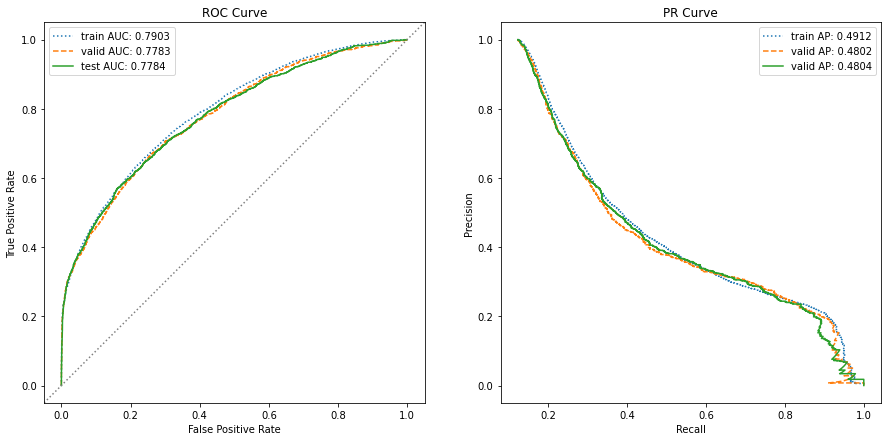

In [32]:
# some visualizations might help!

# auc
fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

fpr_train, tpr_train, _ = roc_curve(y_train, probs_dict['xgb']['train'])
fpr_valid, tpr_valid, _ = roc_curve(y_valid, probs_dict['xgb']['valid'])
fpr_test, tpr_test, _ = roc_curve(y_test, probs_dict['xgb']['test'])

# pr
prec_train, recall_train, _ = precision_recall_curve(y_train, probs_dict['xgb']['train'])
prec_valid, recall_valid, _ = precision_recall_curve(y_valid, probs_dict['xgb']['valid'])
prec_test, recall_test, _ = precision_recall_curve(y_test, probs_dict['xgb']['test'])

ax1.plot(fpr_train, tpr_train, label=f"train AUC: {round(roc_auc_score(y_train, probs_dict['xgb']['train']),4)}",
        linestyle=':')
ax1.plot(fpr_valid, tpr_valid, label=f"valid AUC: {round(roc_auc_score(y_valid, probs_dict['xgb']['valid']),4)}", 
         linestyle='--')
ax1.plot(fpr_test, tpr_test, label=f"test AUC: {round(roc_auc_score(y_test, probs_dict['xgb']['test']),4)}", 
         linestyle='-')
ax1.plot([0, 1], [0, 1], transform=ax1.transAxes, color='gray', linestyle=':')

ax2.plot(prec_train, recall_train, label=f"train AP: {round(average_precision_score(y_train, probs_dict['xgb']['train']),4)}",
        linestyle=':')
ax2.plot(prec_valid, recall_valid, label=f"valid AP: {round(average_precision_score(y_valid, probs_dict['xgb']['valid']),4)}", 
         linestyle='--')
ax2.plot(prec_test, recall_test, label=f"valid AP: {round(average_precision_score(y_test, probs_dict['xgb']['test']),4)}", 
         linestyle='-')

ax1.legend(loc=0)
ax2.legend(loc=0)

ax1.set_title('ROC Curve')
ax2.set_title('PR Curve')

ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')

ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')

plt.show()

Our curves line up nearly perfectly, excelent generalization

Our PR curve suffers from our minority class imbalance

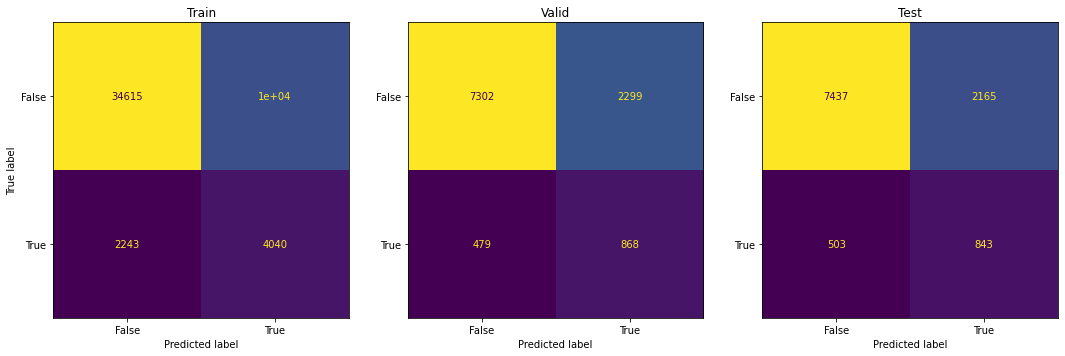

In [33]:
# confusion matrix
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 7))

cm_train = confusion_matrix(y_train, preds_dict['xgb']['train'])

cm_valid = confusion_matrix(y_valid, preds_dict['xgb']['valid'])

cm_test = confusion_matrix(y_test, preds_dict['xgb']['test'])

ConfusionMatrixDisplay(confusion_matrix=cm_train,
                       display_labels=['False', 'True']).plot(ax=ax1, colorbar=False)
ConfusionMatrixDisplay(confusion_matrix=cm_valid,
                       display_labels=['False', 'True']).plot(ax=ax2, colorbar=False)
ConfusionMatrixDisplay(confusion_matrix=cm_test,
                       display_labels=['False', 'True']).plot(ax=ax3, colorbar=False)

ax1.set_title('Train')
ax2.set_title('Valid')
ax3.set_title('Test')

ax2.set_ylabel('')
ax3.set_ylabel('')

plt.show()

Here we can see we have great recall, but our biggest issue is with False Positives, a symptom of our minority class imbalance..We could reevaluate our class weights/ decision boundary if this doesn't line up with expectations.

## `Next Steps`

- **Hyperparameter tuning:** further optimize performance over a wider search space
- **Feature Importance Extraction:** use SHAP, etc. to better explain predictions
- **Ablation Study:** systematically eliminate preprocessing/modeling elements to eliminate needless complexity
- **Cost Analysis:** reduce predictions to $ costs